# Interprétabilité du modèle d'entrainement sur le prix au m² des appartements

Dans ce Notebook, on va interpréter le modèle d'entrainement Gradient Boosting Regressor qui nous permet de determiner le prix d'un appartement dans l'Essonne.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
import shap
from sklearn.ensemble import GradientBoostingRegressor
import joblib
from IPython.display import display
%matplotlib inline

Chargement du dataframe des maisons vendues en 2022 dans le 91 (triée précedement dans le notebook *Entrainement sur les appartements du 91* )

In [2]:
df_appartements = pd.read_csv(r"../data/df_appartements_trait_2022_91_2.csv")

Séparation de la variable cible et des features, puis d'un jeu d'entrainement et de test

In [3]:
data = df_appartements[['surface_reelle_bati', 'nombre_pieces_principales', 'somme_terrain', 'code_commune', 'prix_mcarr_moy_ville', 'Plus_Proche_1', 'Plus_Proche_2', 'Plus_Proche_3']]
target = df_appartements.prix_m_carre

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

Entrainement du modèle avec les hyperparamètres optimaux trouvés dans le précédent Notebook 

In [4]:
model = GradientBoostingRegressor(random_state=42, 
                                  learning_rate = 0.1, 
                                   max_depth= 5,
                                   n_estimators = 50)

# learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50

training_history = model.fit(X_train, y_train)

joblib.dump(model, "../model/modelGBRAppartements2")

y_pred = model.predict(X_test)


percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100 
#Affichage MAPE
print(f"MAPE: {mape}%")

MAPE: 12.19684376572576%


Affichage d'un diagramme en barre, qui permet de connaître les variables qui ont le plus de poids sur l'estimation du bien

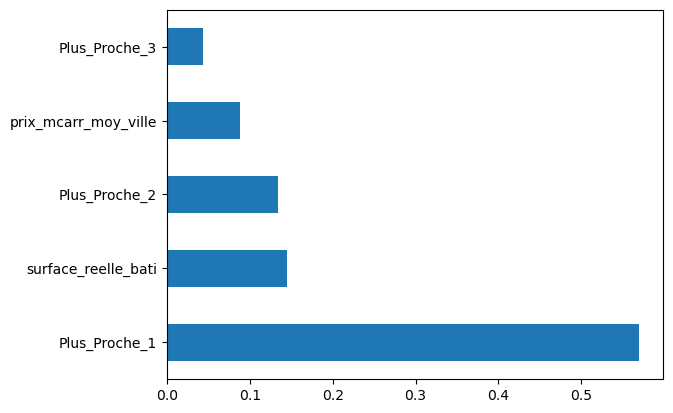

In [5]:
feat_importances = pd.Series(
    model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh');

Utilisation de Shap pour connaître les coefficients de chaque variable et leur contribution

In [6]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(shap_values).head()

Expected Value: [3246.94728041]


,0,1,2,3,4,5,6,7
0,-436.704788,7.206039,-0.731715,0.204854,197.234370,-204.966083,95.668202,18.301076
1,-160.694029,26.134767,-0.411863,2.975697,-172.797439,-662.722818,-255.663153,-141.846052
2,-378.295505,-27.351081,-0.394024,2.126385,340.826528,804.960619,45.568611,94.929392
3,217.666305,13.955690,-0.910750,-21.452630,-220.117463,-408.820903,107.626671,9.968631
4,-279.852659,-41.057654,-0.411863,8.354921,-162.137860,-507.608634,-252.570700,-119.727345


Plot bar des valeurs SHAP

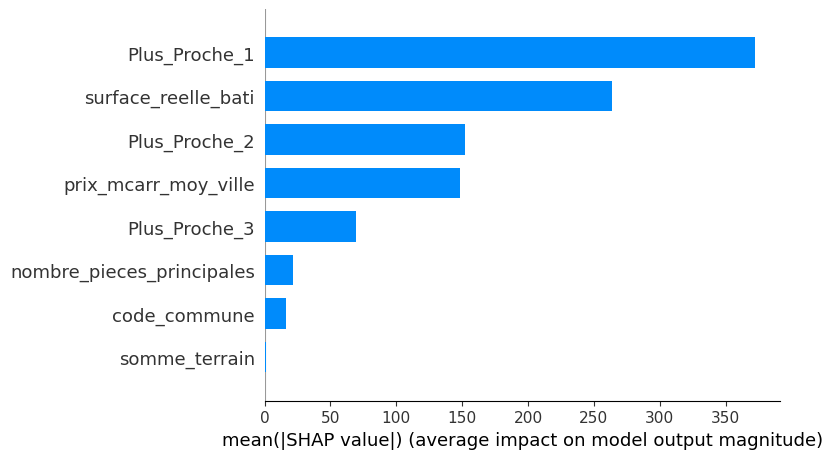

In [7]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Sur ce graphique en barre, on remarque que le prix au m² moyen par ville est la variable qui a le plus de poids sur le prix moyen au m², on remarque aussi que la surface reelle du batiment a aussi un poids élevé.

Affichons maintenant la densité des valeurs Shap


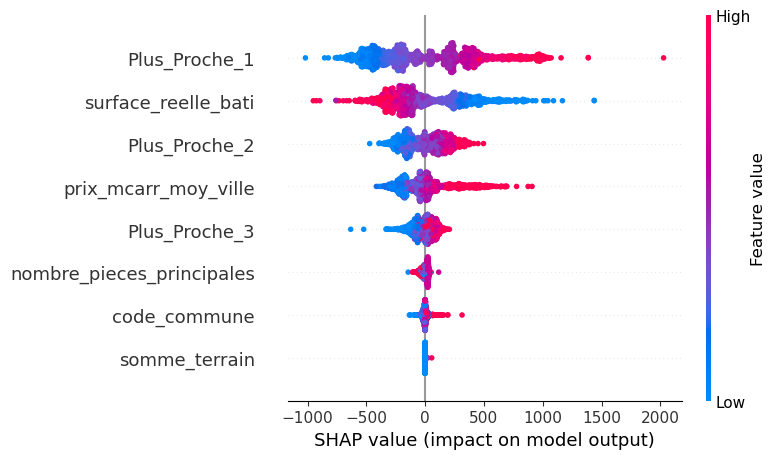

In [8]:
shap.summary_plot(shap_values, X_test)

Ce graphique permet de voir la répartition des valeurs dans les différentes variables, par exemple, il y a une grande quantité d'appartement qui ont 

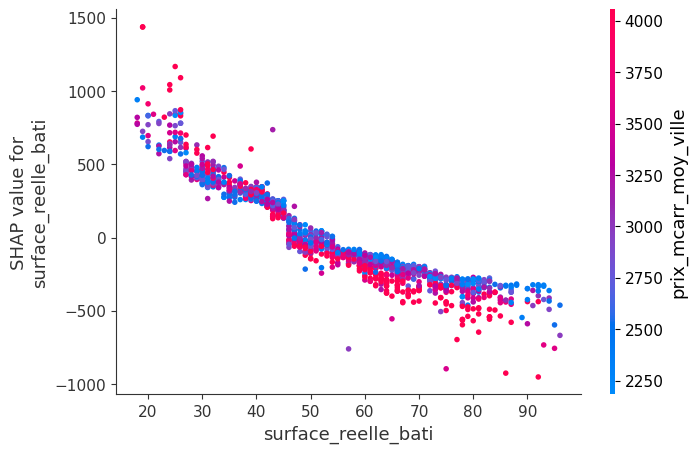

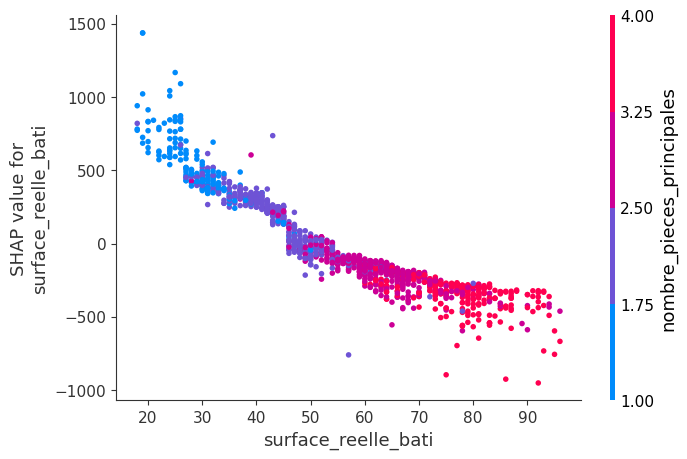

In [9]:
shap.dependence_plot("surface_reelle_bati", shap_values, X_test, interaction_index= "prix_mcarr_moy_ville")

shap.dependence_plot("surface_reelle_bati", shap_values, X_test, interaction_index= "nombre_pieces_principales")

Ici, on étudie la dépendance de chaque variable avec son coefficient SHAP, et sa répartition selon une autre variable.

In [10]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:])

shap.force_plot(explainer.expected_value, shap_values[222,:], X_test.iloc[222,:])

Ici, pour une estimation, on voit le poid qu'à eu chaque variable dans l'estimation du prix.

In [11]:
shap.force_plot(explainer.expected_value, shap_values[:1000], X_test[:1000])

Un autre graphique pour parler de l'interprétabilité, mais plus difficile à lire.

## Meme chose, mais avec LIME

In [12]:
from lime.lime_tabular import LimeTabularExplainer

In [13]:
explainer = LimeTabularExplainer(X_test.values, feature_names=list(X_test.columns), mode = 'regression')

In [14]:
doc_num =24

print('Actual Label:', y_test.iloc[doc_num])
print('Predicted Label:', y_pred[doc_num])
explainer.explain_instance(X_test.iloc[doc_num].values, model.predict).show_in_notebook()

Actual Label: 4529.411764705882
Predicted Label: 4241.675430495006


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


In [15]:
##### import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Créez un petit jeu de données d'entraînement fictif
X_train = np.random.rand(100, 5)
y_train = np.random.rand(100)

# Créez un explainer Lime
explainer = LimeTabularExplainer(X_train, mode="regression")

# Testez l'explication d'une prédiction (remplacez test_data_instance et model.predict par vos propres données)
test_data_instance = X_train[0]
explanation = explainer.explain_instance(test_data_instance, model.predict)

# Affichez l'explication
explanation.show_in_notebook()

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


ValueError: X has 5 features, but GradientBoostingRegressor is expecting 8 features as input.

## Conclusion

Pour conclure ce Notebook, on voit que certaines variables choisies pour ce modèle ont un poid très important dans la décision de l'estimation. Il faudrait trouver d'autres variables qui puissent avoir ce même poids. Cordonnées géographiques, Infrastuctures, indice DPE...
